# Data preparation

### translate Japanese calender to Western calender

JGB data can be downloaded from web page of Ministry of Finance Japan

https://www.mof.go.jp/english/policy/jgbs/reference/interest_rate/index.htm

In [13]:
# preprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def convert_to_gregorian(date_str):
    if pd.isnull(date_str):
        return None
    era_map = {
        "S": 1925,  # 昭和 (S) 開始年 (1926 - 1)
        "H": 1988,  # 平成 (H) 開始年 (1989 - 1)
        "R": 2018   # 令和 (R) 開始年 (2019 - 1)
    }
    era, year, month, day = date_str[0], *map(int, date_str[1:].split('.'))
    gregorian_year = era_map[era] + year
    return f"{gregorian_year:04d}-{month:02d}-{day:02d}"


data = pd.read_csv("jgbcm_all_ed.csv")

# convert the date
data["Date"] = data.iloc[:, 0].apply(convert_to_gregorian)
numeric_cols = data.columns[1:-1]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# delete Unnamed: 0
data = data.drop(columns=["Unnamed: 0"])

cols = ["Date"] + [col for col in data.columns if col != "Date"]
data = data[cols]

# Clean the data: Replace '-' with NaN and convert to numerical values
data = data.replace('-', None)
data.iloc[:, 1:] = data.iloc[:, 1:].astype(float, errors='ignore')
data_cleaned = data.dropna(subset=['Date'])

In [ ]:
# keep the all data
data_all = pd.DataFrame(data)
# delete the columns with all NaN
data_cleaned = pd.DataFrame(data_cleaned).dropna(axis=0)


In [ ]:
# export the cleaned data to a new CSV file
data_cleaned.to_csv("jgbcm_all_ed_cleaned.csv", index=False)

### convert coupone bearing bond rate to zero coupon rate and do smith wilson interpolation and extrapolation

In [3]:
# Smith-wilson interpolation
import pandas as pd
import numpy as np
import math
from IPython.display import display

def hh(z: float) -> float:
    return (z + math.exp(-z)) / 2.0

def Hmat(u: float, v: float) -> float:
    return hh(u + v) - hh(abs(u - v))

def Galfa(alfa: float, Q: np.ndarray, mm: int, umax: int, nrofcoup: int, T2: int, Tau: float):
    size = umax * nrofcoup
    h_mat = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            u_i = alfa * (i + 1) / nrofcoup
            u_j = alfa * (j + 1) / nrofcoup
            h_mat[i, j] = Hmat(u_i, u_j)
    temp1 = []
    for i in range(mm):
        temp1.append(1.0 - np.sum(Q[i, :]))
    temp1 = np.array(temp1).reshape(mm, 1)
    
    Q_h_Qt = Q @ h_mat @ Q.T  # (mm x mm)行列
    inv_Q_h_Qt = np.linalg.inv(Q_h_Qt)
    b = inv_Q_h_Qt @ temp1
    gamma = Q.T @ b
    gamma = gamma.ravel()
    
    temp2 = 0.0
    temp3 = 0.0
    for i in range(size):
        t = (i + 1) / nrofcoup
        temp2 += gamma[i] * t
        temp3 += gamma[i] * math.sinh(alfa * t)
    kappa = (1.0 + alfa * temp2) / temp3
    galfa_val = alfa / abs(1.0 - kappa * math.exp(T2 * alfa))
    return (galfa_val - Tau, gamma)

def AlfaScan(lastalfa: float, stepsize: float, Q: np.ndarray, mm: int, umax: int,
             nrofcoup: int, T2: int, Tau: float):
    scan_start = lastalfa + stepsize/10.0 - stepsize
    scan_end = lastalfa
    scan_step = stepsize / 10.0
    alphas = np.arange(scan_start, scan_end + 1e-12, scan_step)
    for alfa in alphas:
        val, gamma = Galfa(alfa, Q, mm, umax, nrofcoup, T2, Tau)
        if val <= 0:
            return (alfa, gamma)
    return (lastalfa, gamma)

def smith_wilson_brute_force(Instrument: str, data_in: np.ndarray,
                              nrofcoup: int, CRA: float, UFRac: float,
                              alfamin: float, Tau: float, T2: int):
    Tau = Tau / 10000.0

    # data_in[:,0]: Indicator, data_in[:,1]: Maturity, data_in[:,2]: Rate
    indicators = data_in[:, 0]
    mm = int(np.sum(indicators))
    u = []
    r = []
    for row in data_in:
        if row[0] == 1:
            maturity = row[1]
            rate = row[2]
            adj_rate = rate - CRA / 10000.0
            u.append(maturity)
            r.append(adj_rate)
    u = np.array(u, dtype=int)
    r = np.array(r, dtype=float)
    umax = np.max(u)
    lnUFR = math.log(1.0 + UFRac)
    
    if Instrument.lower() == "zero":
        nc = 1
    else:
        nc = nrofcoup

    Q = np.zeros((mm, umax * nc))
    if Instrument.lower() == "zero":
        for i in range(mm):
            maturity_i = u[i]
            rate_i = r[i]
            col_idx = maturity_i - 1
            Q[i, col_idx] = math.exp(-lnUFR * maturity_i) * ((1.0 + rate_i)**maturity_i)
    else:
        for i in range(mm):
            maturity_i = u[i]
            rate_i = r[i]
            for j in range(1, maturity_i * nc):
                col_idx = j - 1
                Q[i, col_idx] = math.exp(-lnUFR * (j / nc)) * (rate_i / nc)
            col_idx = (maturity_i * nc) - 1
            Q[i, col_idx] = math.exp(-lnUFR * maturity_i) * (1.0 + rate_i / nc)
    
    # compute the optimal alpha
    val_min, gamma_min = Galfa(alfamin, Q, mm, umax, nc, T2, Tau)
    if val_min <= 0.0:
        alfa_opt = alfamin
        gamma_opt = gamma_min
    else:
        stepsize = 0.1
        alfa_candidate = alfamin
        found = False
        for alfa in np.arange(alfamin + stepsize, 20.0 + 1e-12, stepsize):
            val, gamma_ = Galfa(alfa, Q, mm, umax, nc, T2, Tau)
            if val <= 0.0:
                alfa_candidate = alfa
                gamma_opt = gamma_
                found = True
                break
        if not found:
            alfa_candidate = 20.0
            _, gamma_opt = Galfa(alfa_candidate, Q, mm, umax, nc, T2, Tau)
        precision = 6
        for _ in range(1, precision):
            alfa_candidate, gamma_opt = AlfaScan(alfa_candidate, stepsize, Q, mm, umax, nc, T2, Tau)
            stepsize /= 10.0
        alfa_opt = alfa_candidate

    size = umax * nc
    h_mat = np.zeros((122, size))
    g_mat = np.zeros((122, size))
    for i in range(122):
        for j in range(size):
            h_mat[i, j] = Hmat(alfa_opt * i, alfa_opt * (j + 1) / nc)
            if ((j + 1) / nc) > i:
                g_mat[i, j] = alfa_opt * (1.0 - math.exp(-alfa_opt * (j + 1) / nc) * math.cosh(alfa_opt * i))
            else:
                g_mat[i, j] = alfa_opt * math.exp(-alfa_opt * i) * math.sinh(alfa_opt * (j + 1) / nc)
    
    tempdiscount = (h_mat @ gamma_opt.reshape(-1, 1)).ravel()
    tempintensity = (g_mat @ gamma_opt.reshape(-1, 1)).ravel()
    
    discount = np.zeros(122)
    fwintensity = np.zeros(122)
    yldintensity = np.zeros(122)
    zeroac = np.zeros(122)
    forwardac = np.zeros(122)
    forwardcc = np.zeros(122)
    zerocc = np.zeros(122)
    
    # i=0
    temp_sum = 0.0
    for j in range(size):
        t = (j + 1) / nc
        temp_sum += (1.0 - math.exp(-alfa_opt * t)) * gamma_opt[j]
    yldintensity[0] = lnUFR - alfa_opt * temp_sum
    fwintensity[0] = yldintensity[0]
    discount[0] = 1.0

    # i=1
    if 1.0 + tempdiscount[1] > 0:
        yldintensity[1] = lnUFR - math.log(1.0 + tempdiscount[1])
        discount[1] = math.exp(-lnUFR) * (1.0 + tempdiscount[1])
    else:
        yldintensity[1] = np.nan
        discount[1] = np.nan

    if discount[1] and discount[1] != 0:
        zeroac[1] = 1.0 / discount[1] - 1.0
    else:
        zeroac[1] = np.nan
    fwintensity[1] = lnUFR - (tempintensity[1] / (1.0 + tempdiscount[1]) if (1.0 + tempdiscount[1]) > 0 else np.nan)
    forwardac[1] = zeroac[1]

    # i = 2～120
    for i in range(2, 121):
        if 1.0 + tempdiscount[i] > 0:
            yldintensity[i] = lnUFR - math.log(1.0 + tempdiscount[i]) / i
        else:
            yldintensity[i] = np.nan
        fwintensity[i] = lnUFR - (tempintensity[i] / (1.0 + tempdiscount[i]) if (1.0 + tempdiscount[i]) > 0 else np.nan)
        discount[i] = math.exp(-lnUFR * i) * (1.0 + tempdiscount[i])
        if discount[i] > 0:
            zeroac[i] = (1.0 / discount[i]) ** (1.0 / i) - 1.0
        else:
            zeroac[i] = np.nan
        forwardac[i] = (discount[i - 1] / discount[i] - 1.0) if discount[i] != 0 else np.nan

    discount[121] = alfa_opt
    yldintensity[121] = 0.0
    fwintensity[121] = 0.0
    zeroac[121] = 0.0
    forwardac[121] = 0.0

    for i in range(1, 121):
        if 1.0 + forwardac[i] > 0:
            forwardcc[i] = math.log(1.0 + forwardac[i])
        else:
            forwardcc[i] = np.nan
        if 1.0 + zeroac[i] > 0:
            zerocc[i] = math.log(1.0 + zeroac[i])
        else:
            zerocc[i] = np.nan

    result = np.column_stack([discount, yldintensity, zeroac, fwintensity, forwardcc, forwardac])
    return result

def run_on_dataframe(df: pd.DataFrame):
    maturity_cols = [col for col in df.columns if col != 'Date']
    results = []
    for idx, row in df.iterrows():
        date = row['Date']
        input_list = []
        for col in maturity_cols:
            rate = row[col]
            if not pd.isna(rate):
                try:
                    maturity = int(col)
                except ValueError:
                    maturity = float(col)
                input_list.append([1, maturity, float(rate)])
        if len(input_list) == 0:
            continue
        data_in = np.array(input_list)
        Instrument = "Bond"
        nrofcoup = 2
        CRA = 0
        UFRac = 0.025
        alfamin = 0.05
        Tau = 1.0
        T2 = 60
        
        sw_result = smith_wilson_brute_force(Instrument, data_in, nrofcoup, CRA, UFRac, alfamin, Tau, T2)
        optimal_alpha = sw_result[-1, 0]
        spot_rates = {}
        for i in range(1, 121):
            spot_rates[str(i)] = sw_result[i, 2]
        spot_rates["optimal_alpha"] = optimal_alpha
        row_result = {"Date": date}
        row_result.update(spot_rates)
        results.append(row_result)
    cols = ["Date"] + [str(i) for i in range(1, 121)] + ["optimal_alpha"]
    return pd.DataFrame(results, columns=cols)

In [ ]:
df_sample = data_all.copy()
df_sample["Date"] = pd.to_datetime(df_sample["Date"])
df_sample = df_sample[(df_sample["Date"] >= "2000-01-01")]
df_sample.iloc[:, 1:] = df_sample.iloc[:, 1:] / 100
df_sample

,Date,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40
6757,2000-01-04,0.00197,0.00402,0.00530,0.00796,0.01013,0.01244,0.01441,0.01552,0.01747,0.01743,0.02164,0.02400,NaN,0.02519,NaN
6758,2000-01-05,0.00183,0.00380,0.00501,0.00766,0.00977,0.01210,0.01404,0.01520,0.01723,0.01718,0.02136,0.02378,NaN,0.02501,NaN
6759,2000-01-06,0.00192,0.00388,0.00504,0.00764,0.00974,0.01201,0.01390,0.01507,0.01707,0.01710,0.02117,0.02362,NaN,0.02486,NaN
6760,2000-01-07,0.00196,0.00406,0.00543,0.00811,0.01026,0.01247,0.01435,0.01548,0.01740,0.01738,0.02145,0.02384,NaN,0.02496,NaN
6761,2000-01-11,0.00205,0.00421,0.00562,0.00827,0.01035,0.01248,0.01433,0.01547,0.01729,0.01735,0.02134,0.02372,NaN,0.02487,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12881,2024-12-24,0.00397,0.00588,0.00584,0.00655,0.00733,0.00738,0.00798,0.00879,0.00971,0.01086,0.01535,0.01863,0.02061,0.02228,0.02545
12882,2024-12-25,0.00399,0.00588,0.00585,0.00656,0.00726,0.00738,0.00797,0.00879,0.00972,0.01086,0.01531,0.01859,0.02057,0.02219,0.02536
12883,2024-12-26,0.00409,0.00602,0.00599,0.00674,0.00746,0.00762,0.00828,0.00909,0.00996,0.01103,0.01544,0.01873,0.02064,0.02231,0.02536
12884,2024-12-27,0.00413,0.00602,0.00606,0.00685,0.00760,0.00773,0.00837,0.00918,0.01008,0.01119,0.01565,0.01898,0.02091,0.02259,0.02560


In [ ]:
result_df = run_on_dataframe(df_sample)
result_df.to_csv("daily_smith_wilson_20000101_.csv", index=False)

### compare the python conversion with EIOPA execel tool

In [ ]:
compare_df = pd.read_csv("DGPinput_JPY_long_add40.csv")
compare_df["Date"] = pd.to_datetime(compare_df["Date"])
compare_df.set_index("Date", inplace=True)

In [ ]:
# compare smith wilson calculation done by python and excel
result_df = pd.read_csv("daily_smith_wilson_20000101_.csv")
result_df["Date"] = pd.to_datetime(result_df["Date"])
result_df.set_index("Date", inplace=True)

result_df = result_df.reindex(compare_df.index)
compare_columns = compare_df.columns[0:]
result_df = result_df[compare_columns]

# Calculate the absolute difference
diff_df = abs(result_df - compare_df)
# Display the differences
diff_df = diff_df.reset_index()

Text(0.5, 1.0, 'Difference between Smith-Wilson and DGP')

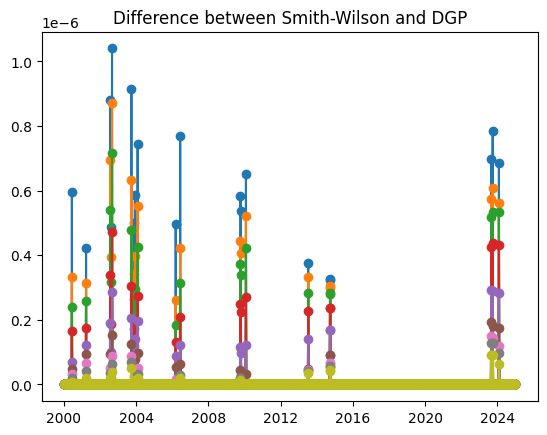

In [77]:
plt.plot(diff_df["Date"], diff_df.iloc[:, 1:], marker='o')
plt.title("Difference between Smith-Wilson and DGP")

In [78]:
mean_diff = diff_df.mean()
numeric_cols = diff_df.select_dtypes(include=['number'])
mean_numeric = numeric_cols.mean() * 100
mean_numeric

1     1.019313e-06
5     7.688569e-07
7     6.341599e-07
10    4.541898e-07
15    2.908699e-07
20    1.703211e-07
25    1.148022e-07
30    9.548870e-08
40    7.251090e-08
dtype: float64

The difference between the result from python code and one from EIOPA tool is tivial    

### Graph for presentation

In [ ]:
# chnage UFR to 3.8% 
import pandas as pd
import numpy as np
import math
from IPython.display import display

def hh(z: float) -> float:
    return (z + math.exp(-z)) / 2.0

def Hmat(u: float, v: float) -> float:
    return hh(u + v) - hh(abs(u - v))

def Galfa(alfa: float, Q: np.ndarray, mm: int, umax: int, nrofcoup: int, T2: int, Tau: float):
    size = umax * nrofcoup
    h_mat = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            u_i = alfa * (i + 1) / nrofcoup
            u_j = alfa * (j + 1) / nrofcoup
            h_mat[i, j] = Hmat(u_i, u_j)
    temp1 = []
    for i in range(mm):
        temp1.append(1.0 - np.sum(Q[i, :]))
    temp1 = np.array(temp1).reshape(mm, 1)
    
    Q_h_Qt = Q @ h_mat @ Q.T  # (mm x mm)行列
    inv_Q_h_Qt = np.linalg.inv(Q_h_Qt)
    b = inv_Q_h_Qt @ temp1
    gamma = Q.T @ b
    gamma = gamma.ravel()
    
    temp2 = 0.0
    temp3 = 0.0
    for i in range(size):
        t = (i + 1) / nrofcoup
        temp2 += gamma[i] * t
        temp3 += gamma[i] * math.sinh(alfa * t)
    kappa = (1.0 + alfa * temp2) / temp3
    galfa_val = alfa / abs(1.0 - kappa * math.exp(T2 * alfa))
    return (galfa_val - Tau, gamma)

def AlfaScan(lastalfa: float, stepsize: float, Q: np.ndarray, mm: int, umax: int,
             nrofcoup: int, T2: int, Tau: float):
    scan_start = lastalfa + stepsize/10.0 - stepsize
    scan_end = lastalfa
    scan_step = stepsize / 10.0
    alphas = np.arange(scan_start, scan_end + 1e-12, scan_step)
    for alfa in alphas:
        val, gamma = Galfa(alfa, Q, mm, umax, nrofcoup, T2, Tau)
        if val <= 0:
            return (alfa, gamma)
    return (lastalfa, gamma)

def smith_wilson_brute_force(Instrument: str, data_in: np.ndarray,
                              nrofcoup: int, CRA: float, UFRac: float,
                              alfamin: float, Tau: float, T2: int):
    Tau = Tau / 10000.0

    # data_in[:,0]: Indicator, data_in[:,1]: Maturity, data_in[:,2]: Rate
    indicators = data_in[:, 0]
    mm = int(np.sum(indicators))
    u = []
    r = []
    for row in data_in:
        if row[0] == 1:
            maturity = row[1]
            rate = row[2]
            adj_rate = rate - CRA / 10000.0
            u.append(maturity)
            r.append(adj_rate)
    u = np.array(u, dtype=int)
    r = np.array(r, dtype=float)
    umax = np.max(u)
    lnUFR = math.log(1.0 + UFRac)
    
    if Instrument.lower() == "zero":
        nc = 1
    else:
        nc = nrofcoup

    Q = np.zeros((mm, umax * nc))
    if Instrument.lower() == "zero":
        for i in range(mm):
            maturity_i = u[i]
            rate_i = r[i]
            col_idx = maturity_i - 1
            Q[i, col_idx] = math.exp(-lnUFR * maturity_i) * ((1.0 + rate_i)**maturity_i)
    else:
        for i in range(mm):
            maturity_i = u[i]
            rate_i = r[i]
            for j in range(1, maturity_i * nc):
                col_idx = j - 1
                Q[i, col_idx] = math.exp(-lnUFR * (j / nc)) * (rate_i / nc)
            col_idx = (maturity_i * nc) - 1
            Q[i, col_idx] = math.exp(-lnUFR * maturity_i) * (1.0 + rate_i / nc)
    
    # compute the optimal alpha
    val_min, gamma_min = Galfa(alfamin, Q, mm, umax, nc, T2, Tau)
    if val_min <= 0.0:
        alfa_opt = alfamin
        gamma_opt = gamma_min
    else:
        stepsize = 0.1
        alfa_candidate = alfamin
        found = False
        for alfa in np.arange(alfamin + stepsize, 20.0 + 1e-12, stepsize):
            val, gamma_ = Galfa(alfa, Q, mm, umax, nc, T2, Tau)
            if val <= 0.0:
                alfa_candidate = alfa
                gamma_opt = gamma_
                found = True
                break
        if not found:
            alfa_candidate = 20.0
            _, gamma_opt = Galfa(alfa_candidate, Q, mm, umax, nc, T2, Tau)
        precision = 6
        for _ in range(1, precision):
            alfa_candidate, gamma_opt = AlfaScan(alfa_candidate, stepsize, Q, mm, umax, nc, T2, Tau)
            stepsize /= 10.0
        alfa_opt = alfa_candidate

    size = umax * nc
    h_mat = np.zeros((122, size))
    g_mat = np.zeros((122, size))
    for i in range(122):
        for j in range(size):
            h_mat[i, j] = Hmat(alfa_opt * i, alfa_opt * (j + 1) / nc)
            if ((j + 1) / nc) > i:
                g_mat[i, j] = alfa_opt * (1.0 - math.exp(-alfa_opt * (j + 1) / nc) * math.cosh(alfa_opt * i))
            else:
                g_mat[i, j] = alfa_opt * math.exp(-alfa_opt * i) * math.sinh(alfa_opt * (j + 1) / nc)
    
    tempdiscount = (h_mat @ gamma_opt.reshape(-1, 1)).ravel()
    tempintensity = (g_mat @ gamma_opt.reshape(-1, 1)).ravel()
    
    discount = np.zeros(122)
    fwintensity = np.zeros(122)
    yldintensity = np.zeros(122)
    zeroac = np.zeros(122)
    forwardac = np.zeros(122)
    forwardcc = np.zeros(122)
    zerocc = np.zeros(122)
    
    # i=0
    temp_sum = 0.0
    for j in range(size):
        t = (j + 1) / nc
        temp_sum += (1.0 - math.exp(-alfa_opt * t)) * gamma_opt[j]
    yldintensity[0] = lnUFR - alfa_opt * temp_sum
    fwintensity[0] = yldintensity[0]
    discount[0] = 1.0

    # i=1
    if 1.0 + tempdiscount[1] > 0:
        yldintensity[1] = lnUFR - math.log(1.0 + tempdiscount[1])
        discount[1] = math.exp(-lnUFR) * (1.0 + tempdiscount[1])
    else:
        yldintensity[1] = np.nan
        discount[1] = np.nan

    if discount[1] and discount[1] != 0:
        zeroac[1] = 1.0 / discount[1] - 1.0
    else:
        zeroac[1] = np.nan
    fwintensity[1] = lnUFR - (tempintensity[1] / (1.0 + tempdiscount[1]) if (1.0 + tempdiscount[1]) > 0 else np.nan)
    forwardac[1] = zeroac[1]

    # i = 2～120
    for i in range(2, 121):
        if 1.0 + tempdiscount[i] > 0:
            yldintensity[i] = lnUFR - math.log(1.0 + tempdiscount[i]) / i
        else:
            yldintensity[i] = np.nan
        fwintensity[i] = lnUFR - (tempintensity[i] / (1.0 + tempdiscount[i]) if (1.0 + tempdiscount[i]) > 0 else np.nan)
        discount[i] = math.exp(-lnUFR * i) * (1.0 + tempdiscount[i])
        if discount[i] > 0:
            zeroac[i] = (1.0 / discount[i]) ** (1.0 / i) - 1.0
        else:
            zeroac[i] = np.nan
        forwardac[i] = (discount[i - 1] / discount[i] - 1.0) if discount[i] != 0 else np.nan

    discount[121] = alfa_opt
    yldintensity[121] = 0.0
    fwintensity[121] = 0.0
    zeroac[121] = 0.0
    forwardac[121] = 0.0

    for i in range(1, 121):
        if 1.0 + forwardac[i] > 0:
            forwardcc[i] = math.log(1.0 + forwardac[i])
        else:
            forwardcc[i] = np.nan
        if 1.0 + zeroac[i] > 0:
            zerocc[i] = math.log(1.0 + zeroac[i])
        else:
            zerocc[i] = np.nan

    result = np.column_stack([discount, yldintensity, zeroac, fwintensity, forwardcc, forwardac])
    return result

def run_on_dataframe(df: pd.DataFrame):
    maturity_cols = [col for col in df.columns if col != 'Date']
    results = []
    for idx, row in df.iterrows():
        date = row['Date']
        input_list = []
        for col in maturity_cols:
            rate = row[col]
            if not pd.isna(rate):
                try:
                    maturity = int(col)
                except ValueError:
                    maturity = float(col)
                input_list.append([1, maturity, float(rate)])
        if len(input_list) == 0:
            continue
        data_in = np.array(input_list)
        Instrument = "Bond"
        nrofcoup = 2
        CRA = 0
        UFRac = 0.038
        alfamin = 0.05
        Tau = 1.0
        T2 = 60
        
        sw_result = smith_wilson_brute_force(Instrument, data_in, nrofcoup, CRA, UFRac, alfamin, Tau, T2)
        optimal_alpha = sw_result[-1, 0]
        spot_rates = {}
        for i in range(1, 121):
            spot_rates[str(i)] = sw_result[i, 2]
        spot_rates["optimal_alpha"] = optimal_alpha
        row_result = {"Date": date}
        row_result.update(spot_rates)
        results.append(row_result)
    cols = ["Date"] + [str(i) for i in range(1, 121)] + ["optimal_alpha"]
    return pd.DataFrame(results, columns=cols)

In [ ]:
df = pd.read_csv("jgbcm_all_ed_cleaned.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df[(df["Date"] == "2023-03-31")]
df = df.drop(columns=["40"])
df.iloc[:, 1:] = df.iloc[:, 1:] / 100
df


,Date,1,2,3,4,5,6,7,8,9,10,15,20,25,30
3765,2023-03-31,-0.00115,-0.00061,-0.00052,0.00024,0.00104,0.00147,0.00212,0.00303,0.00301,0.00389,0.00784,0.01044,0.01189,0.01274


In [ ]:
SW_lot30 = run_on_dataframe(df)
SW_lot30 

,Date,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,optimal_alpha
0,2023-03-31,-0.00115,-0.00061,-0.00052,0.00024,0.001043,0.001476,0.002132,0.003055,0.003032,...,0.030572,0.030637,0.030702,0.030765,0.030827,0.030888,0.030948,0.031007,0.031065,0.164429


In [17]:
df2 = pd.read_csv("daily_smith_wilson_20000101_.csv")
SW_lot40 = df2[df2["Date"] == "2023-03-31"]

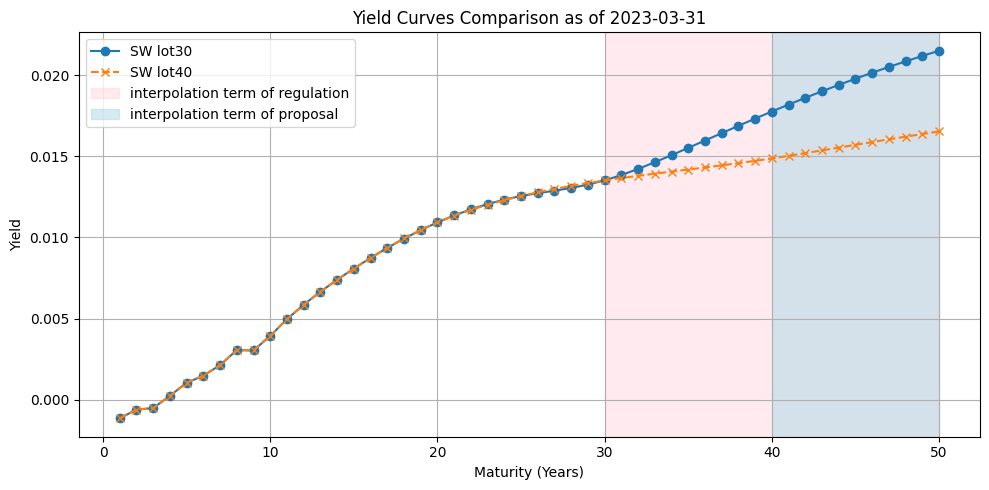

In [30]:
maturity_cols = [str(i) for i in range(1, 51)]

y30 = SW_lot30[maturity_cols].iloc[0].astype(float).values
y40 = SW_lot40[maturity_cols].iloc[0].astype(float).values
maturities = list(range(1, 51))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(maturities, y30, marker='o', linestyle='-', label="SW lot30")
ax.plot(maturities, y40, marker='x', linestyle='--', label="SW lot40")

ax.axvspan(30, 50, color='pink', alpha=0.3, label="interpolation term of regulation")
ax.axvspan(40, 50, color='lightblue', alpha=0.5, label="interpolation term of proposal")

ax.set_xlabel("Maturity (Years)")
ax.set_ylabel("Yield")
ax.set_title("Yield Curves Comparison as of 2023-03-31")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


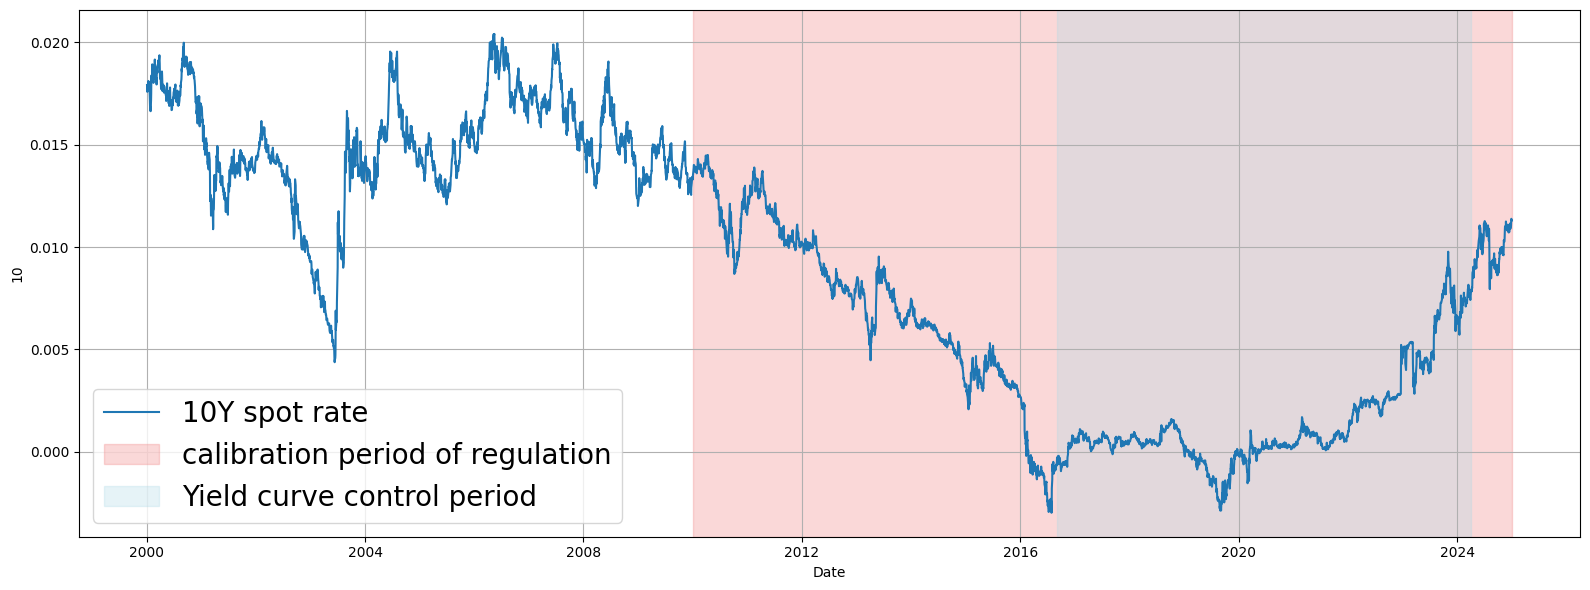

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("daily_smith_wilson_20000101_.csv")
df["Date"] = pd.to_datetime(df["Date"])

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["Date"], df.iloc[:, 10], label="10Y spot rate")

start_red = pd.Timestamp("2010-01-01")
end_red   = df["Date"].max()
ax.axvspan(start_red, end_red, color="lightcoral", alpha=0.3, label="calibration period of regulation")

start_blue = pd.Timestamp("2016-09-01")
end_blue   = pd.Timestamp("2024-03-31")
ax.axvspan(start_blue, end_blue, color="lightblue", alpha=0.3, label="Yield curve control period")

ax.set_xlabel("Date")
ax.set_ylabel(df.columns[10])
ax.legend(fontsize=20)
ax.grid(True)

plt.tight_layout()
plt.show()


# Check the distribution of the change of JPY rates (check the difference between the time horizon)

Maximum changes for the selected maturity ( 10 years):
Daily change (w=1): 0.0021958475505537006
Weekly change (w=5): 0.005026746607027701
Monthly change (w=21): 0.007123229527744999
Yearly change (w=252): 0.014911394219393498


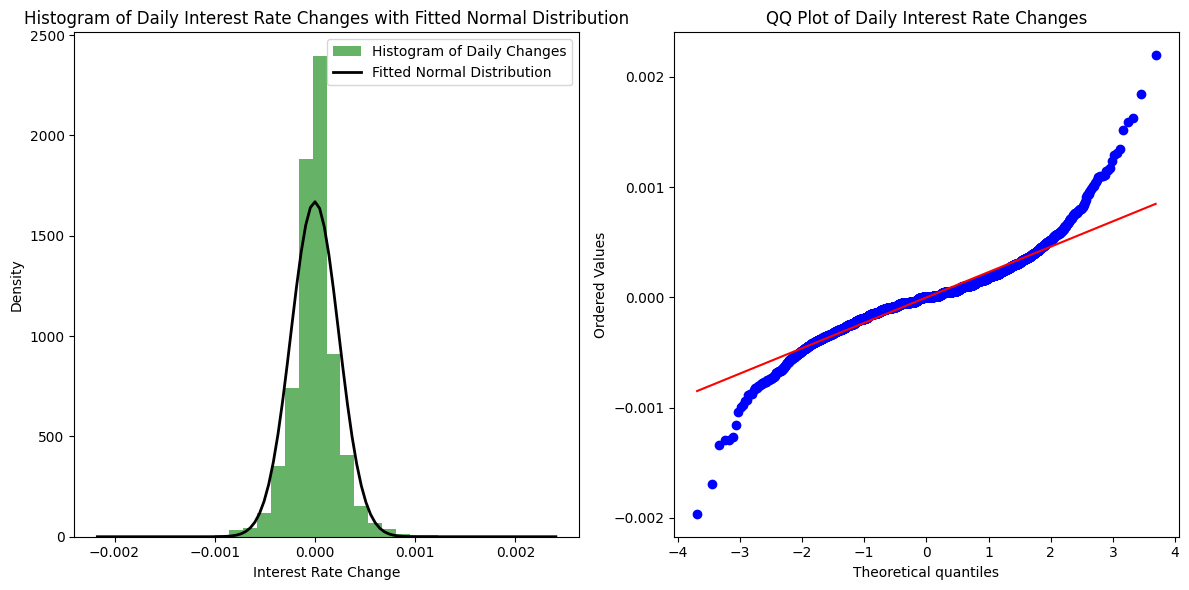

Anderson-Darling Test for Normality:
Statistic: 90.20415115091328
Critical Values: [0.576 0.656 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
Jarque-Bera Test for Normality:
JB Statistic: 12130.131644023322
p-value: 0.0


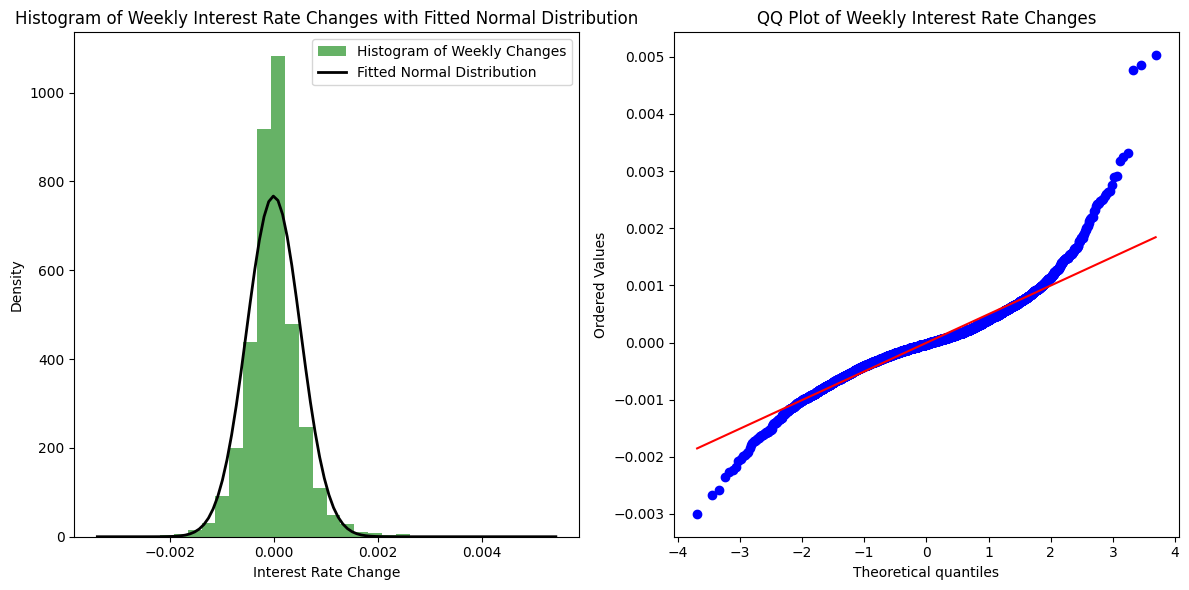

Anderson-Darling Test for Normality:
Statistic: 83.4950492699927
Critical Values: [0.576 0.656 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
Jarque-Bera Test for Normality:
JB Statistic: 15033.465144719597
p-value: 0.0


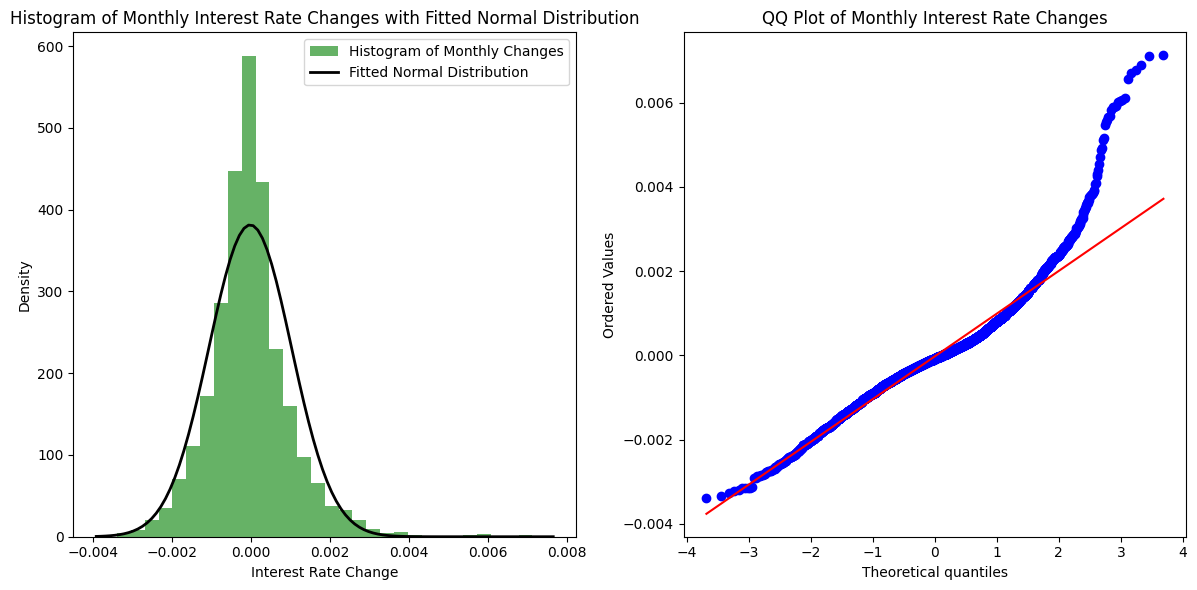

Anderson-Darling Test for Normality:
Statistic: 71.53555524113744
Critical Values: [0.576 0.656 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
Jarque-Bera Test for Normality:
JB Statistic: 6989.3891899306645
p-value: 0.0


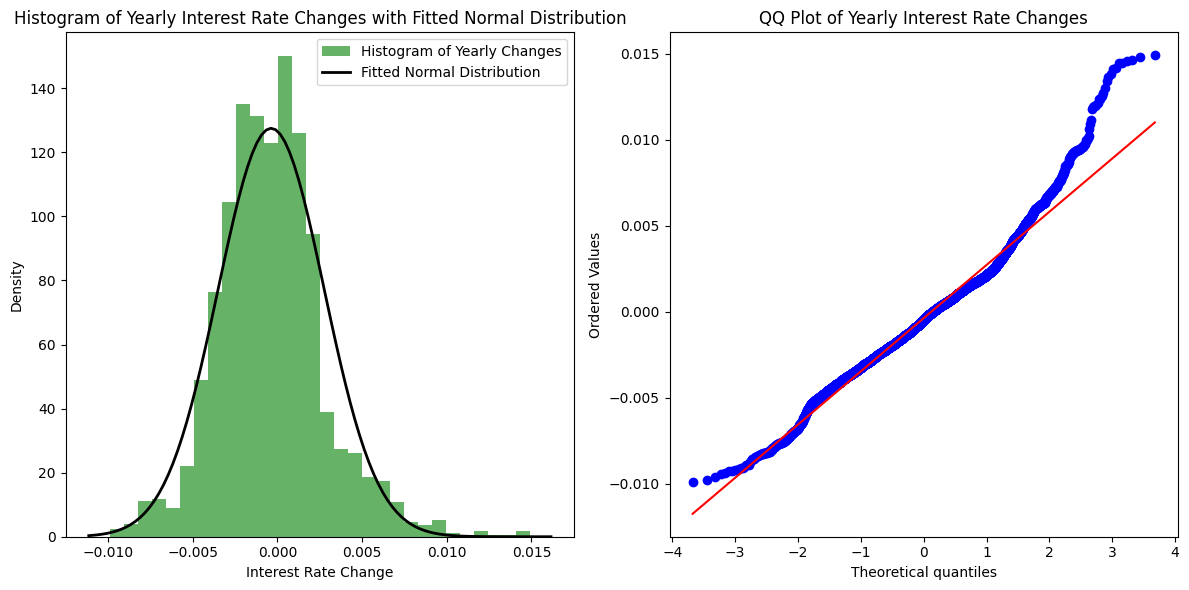

Anderson-Darling Test for Normality:
Statistic: 25.655556542013983
Critical Values: [0.576 0.656 0.786 0.917 1.091]
Significance Levels: [15.  10.   5.   2.5  1. ]
Jarque-Bera Test for Normality:
JB Statistic: 939.6264888716493
p-value: 9.17699333858213e-205


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv("daily_smith_wilson_20000101_.csv")
df["Date"] = pd.to_datetime(df["Date"])
target_maturity = "10"

# Extract the time series of interest rates for the specified maturity
start_date = pd.to_datetime('2000-01-01')
end_date   = pd.to_datetime('2024-12-31')
mask = (df["Date"] >= start_date) & (df["Date"] <= end_date)
df_analysis = df.loc[mask].copy()

yield_series = df_analysis[target_maturity]

# Define window sizes for different time horizons
w_daily = 1
w_weekly = 5
w_monthly = 21
w_yearly = 252

# Calculate the change over the specified horizon by taking the difference with the data w steps ahead.
# (Forward difference: change = future value - current value)
daily_changes = yield_series.shift(-w_daily) - yield_series
weekly_changes = yield_series.shift(-w_weekly) - yield_series
monthly_changes = yield_series.shift(-w_monthly) - yield_series
yearly_changes = yield_series.shift(-w_yearly) - yield_series

# Drop NaN values that result from shifting (at the tail of the series)
daily_changes = daily_changes.dropna()
weekly_changes = weekly_changes.dropna()
monthly_changes = monthly_changes.dropna()
yearly_changes = yearly_changes.dropna()

max_daily_change = daily_changes.abs().max()
max_weekly_change = weekly_changes.abs().max()
max_monthly_change = monthly_changes.abs().max()
max_yearly_change = yearly_changes.abs().max()

print("Maximum changes for the selected maturity (", target_maturity, "years):")
print("Daily change (w=1):", max_daily_change)
print("Weekly change (w=5):", max_weekly_change)
print("Monthly change (w=21):", max_monthly_change)
print("Yearly change (w=252):", max_yearly_change)

time_horizons = {
    "Daily": daily_changes,
    "Weekly": weekly_changes,
    "Monthly": monthly_changes,
    "Yearly": yearly_changes
}

for label, changes in time_horizons.items():

    # Histogram with fitted normal distribution curve
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    mu, std = stats.norm.fit(changes)
    n, bins, patches = plt.hist(changes, bins=30, density=True, alpha=0.6, color='g', label=f"Histogram of {label} Changes")
    xmin, xmax = plt.xlim()
    x_vals = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x_vals, mu, std)
    plt.plot(x_vals, p, 'k', linewidth=2, label="Fitted Normal Distribution")
    plt.xlabel("Interest Rate Change")
    plt.ylabel("Density")
    plt.title(f"Histogram of {label} Interest Rate Changes with Fitted Normal Distribution")
    plt.legend()
    
    # QQ plot
    plt.subplot(1,2,2)
    stats.probplot(changes, dist ="norm", plot=plt)
    plt.title(f"QQ Plot of {label} Interest Rate Changes")
    
    plt.tight_layout()
    plt.show()

    # Anderson-Darling Test for Normality
    ad_result = stats.anderson(changes, dist='norm')
    print("Anderson-Darling Test for Normality:")
    print("Statistic:", ad_result.statistic)
    print("Critical Values:", ad_result.critical_values)
    print("Significance Levels:", ad_result.significance_level)

    # Jarque-Bera Test for Normality
    jb_stat, jb_pvalue = stats.jarque_bera(changes)
    print("Jarque-Bera Test for Normality:")
    print("JB Statistic:", jb_stat)
    print("p-value:", jb_pvalue)


# Other

### for proposal report

In [ ]:
df = df[df["Date"] >= "2008-01-01"]
stats_df = pd.DataFrame({
    'Count': df.count(),
    'Mean': df.mean(),
    'Std': df.std(),
    'Min': df.min(),
    'Median': df.median(),
    'Max': df.max()
})
latex_table = stats_df.to_latex(float_format="%.2f", caption="Descriptive Statistics", label="tab:statistics")

print(latex_table)

## export weekly data for smith-wilson interpolation in excel (used for initial phase calculation)

In [ ]:
df = data_all.copy()
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
weekly_df = df.resample("W-FRI").last().reset_index()
weekly_df.to_csv("jgbcm_all_weekly_test.csv", index=False)

In [ ]:
# for Kalman filter program
df = weekly_df[weekly_df["Date"] >= "2000-01-01"].reset_index(drop=True)
# conver Nan to "-"
df = df.fillna("-")
df.to_csv("jgbcm_all_weekly_for_smith_wilson.csv", index=False)
df

,Date,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40
0,2000-01-07,0.196,0.406,0.543,0.811,1.026,1.247,1.435,1.548,1.74,1.738,2.145,2.384,-,2.496,-
1,2000-01-14,0.193,0.414,0.555,0.816,1.03,1.249,1.444,1.564,1.74,1.75,2.133,2.36,-,2.476,-
2,2000-01-21,0.2,0.41,0.564,0.821,1.032,1.238,1.413,1.538,1.697,1.722,2.131,2.346,-,2.461,-
3,2000-01-28,0.182,0.371,0.489,0.731,0.931,1.13,1.28,1.431,1.595,1.62,2.032,2.248,-,2.357,-
4,2000-02-04,0.199,0.421,0.563,0.829,0.983,1.285,1.467,1.6,1.737,1.761,2.198,2.373,-,2.427,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,2024-12-06,0.446,0.59,0.606,0.666,0.725,0.723,0.769,0.852,0.948,1.068,1.526,1.861,2.075,2.236,2.57
1301,2024-12-13,0.412,0.564,0.573,0.638,0.697,0.708,0.761,0.842,0.935,1.055,1.504,1.848,2.048,2.22,2.551
1302,2024-12-20,0.39,0.576,0.573,0.643,0.706,0.719,0.773,0.855,0.949,1.07,1.526,1.855,2.054,2.229,2.559
1303,2024-12-27,0.413,0.602,0.606,0.685,0.76,0.773,0.837,0.918,1.008,1.119,1.565,1.898,2.091,2.259,2.56
